In [1]:
using LinearAlgebra
using Plots

In [2]:
"""
Podatkovni tip za razprseno matriko.

Matrika je razdeljena na dve matriki, V in I. V hrani vse neničelne vrenosti matrike, I pa indexe teh vrednosti.

A = RazprsenaMatrika([1 2; 1 0; 1 2], [1 2; 2 0 ; 2 3]) —>

[1 2 0]
[0 1 0]
[0 1 2]

"""

mutable struct RazprsenaMatrika{T} <: AbstractArray{T,2}
    V::Matrix{T}
    I::Matrix{Int64}
end

import Base:size,getindex,setindex!

"""
    size(A)

    Vrne velikost razprsene matrike

"""
function size(A::RazprsenaMatrika)
    return (size(A.V)[1],maximum(A.I))
end
    
"""
    getindex(A,I) ali A[i,j]

    Vrne element na mestu i,j

"""
function getindex(A::RazprsenaMatrika, I::Vararg{Int,2})
    
    if I > size(A)
        return 0
    end
    
    i = I[1]
    j = I[2]
    
    for col=1:size(A.I)[2]
        if j == A.I[i,col]
            return A.V[i,col]
        end
    end
    
    return 0
            
end

"""
    setindex!(A,v,I) ali A[i,j] = v

    Nastavi element na mestu i, j na v.

"""
function setindex!(A::RazprsenaMatrika, v, I::Vararg{Int,2})
    
    if I > size(A)
        return
    end
    
    i = I[1]
    j = I[2]
    
    #if input is zero, find the entry, remove it, and move the rest of the entries to fill the gap
    if v == 0
        for col=1:size(A.I)[2]
            if j == A.I[i,col]
                for er=col:size(A.I)[2]-1
                    #display(col)
                    A.I[i,er] = A.I[i,er+1]
                    A.V[i,er] = A.V[i,er+1]
                end
                A.I[i,size(A.I)[2]] = 0
                A.V[i,size(A.V)[2]] = 0
            end
        end
        return
    end
    
    #check if there is room for one more value in the row, and if not, append another empty row
    if A.I[i,size(A.I)[2]] != 0
        A.I = hcat(A.I,zeros(size(A.I)[1]))
        A.V = hcat(A.V,zeros(size(A.V)[1]))   
    end

    #find the value in the sparse representation
    for col=1:size(A.I)[2]
        if j == A.I[i,col] || A.I[i,col] == 0    #if the A[i,j] is nonzero, we can just replace the value
            A.I[i,col] = j                       #same if all values in I are smaller than j, we can just replace the last zero
            A.V[i,col] = v
            return
        end
        if j < A.I[i,col]                        #if j is in the middle of the row, we move all values forward one place, then replace the value at i,j
            for er=size(A.I)[2]-1:-1:col
                #display(col)
                A.I[i,er+1] = A.I[i,er]
                A.V[i,er+1] = A.V[i,er]
            end
            A.I[i,col] = j
            A.V[i,col] = v
            return
        end
    end
        
end

Base.setindex!

In [15]:
import Base:firstindex,lastindex

"""
    Funkciji, ki vrneta prvi in zadnji index matrike
"""

function firstindex(A::RazprsenaMatrika)
    
    for i=1:size(A.I)[1]
         if A.I[i][1] != 0
            return (i-1)*size(A)[2]+A.I[i][1]
        end
    end
        
    return 0
            
end

function lastindex(A::RazprsenaMatrika)
    
    for i=size(A.I)[1]:1
         if A.I[i][1] != 0
            return (i-1)*size(A)[2],maximum(A.I[i])
        end
    end
        
    return size(A)[1] * size(A)[2]
            
end

lastindex (generic function with 22 methods)

In [3]:
import Base:*
#using LinearAlgebra

"""
    A*v
    Množenje razprsene matrike A s vektorjem v
"""
function *(A::RazprsenaMatrika,v::Vector)
    
    y = zeros(size(A)[1])

    for i=1:size(A)[1]
        for col=1:size(A.I)[2]
            j = A.I[i,col]
            if j != 0
                y[i]+=v[j]*A[i,j]
            end
        end
    end
    
    return y
end

"""
    x, it = sor(A,b,x0,omega,tol,maxiter)

    Izračuna rešitev sistema Ax = b s SOR iteracijo.

    Vrne končno rešitev x in število iteracij.
"""
function sor(A::RazprsenaMatrika, b::Vector, x0, omega, tol=1e-10, maxiter=100)
    it = 0
    x = x0

    #display(A)
    #display(x)
    #display(b)
    
    res = norm(A*x-b,Inf)
    
    while res > tol && it < maxiter
        #display(x)
        for i=1:size(A)[1]
            sigma = 0
            for col=1:size(A.I)[2]
                j = A.I[i,col]
                if j != i && j != 0
                     sigma += A.V[i,col] * x[j]
                end
            end
            x[i] = (1-omega)*x[i] + (omega/A[i,i])*(b[i]-sigma)
        end
        res = norm(A*x-b,Inf)
        it += 1
    end
    
    return x,it
    
end

sor

In [60]:
"""
    adjmat, b = get_graph(n,edgelist,fixed,values)

    Izračuna matriko in desne vrednosti za računanje vložitve grafa po eni dimenziji.
    Graf je podan v obliki seznama povezav, seznama fiksiranih vozlišč in položaji teh vozlišč.
    Fixirana vozlišča morajo biti urejena padajoče
"""
function get_graph(n, edgelist, fixed, values)
    adjmat = zeros(n,n)
    #adjmat = RazprsenaMatrika(zeros(n,2), zeros(Int64,n,2))
    b = zeros(n)
    
    #display(adjmat)
    #display(edgelist)
    
    #initialize the adjacency matrix
    for edge in edgelist
        adjmat[edge[1],edge[2]] = 1.0
        adjmat[edge[2],edge[1]] = 1.0
    end
    
    #per the embedding equation: all neighbours of node have weight 1, while the node itself has weight -n of nodes
    for i=1:n
        adjmat[i,i] = -sum(adjmat[i,:])
    end
    
    #move the fixed nodes to right side
    for i=1:length(fixed)
        b -= adjmat[fixed[i],:]*values[i]
        
    end
    
    #display(adjmat)
    
    #remove the fixed nodes from the system
    for i in fixed
        adjmat = adjmat[1:end .!= i,1:end .!= i]
        b = b[1:end .!= i]
    end
    
    #display(adjmat)
    #display(b)
    
    return adjmat,b
    
end

"""
    raz_mat = mat_to_razprsena(mat)

    Pretvori matriko v katerikoli obliki v razprseno matriko.
"""
function mat_to_razprsena(mat)
    n = size(mat)[1]
    raz_mat = RazprsenaMatrika(zeros(n,2), zeros(Int64,n,2))
    for i=1:n
        for j=1:n
            raz_mat[i,j] = mat[i,j]
        end
    end
    return raz_mat
end

"""
    edges = get_loop_graph(n)

    Vrne krožni graf, kjer je vsako vozlišče povezano na dva najbljižja soseda
"""
function get_loop_graph(n)
    edges = [(n,1)]
    for i=1:n-1
        edges = vcat(edges,(i,i+1))
    end
    return edges
end

"""
    edges = get_loop_graph(n)

    Vrne naključni graf
"""

function get_random_graph(n,p)
    edges = [(0,0)]
    for i=1:n-1
        for j=i+1:n
            if rand(Float64) < p
                edges = vcat(edges,(i,j))
            end
        end
    end
    return edges[2:end]
end

get_random_graph (generic function with 1 method)

In [62]:
get_random_graph(5,0.5)

6-element Array{Tuple{Int64,Int64},1}:
 (1, 2)
 (1, 5)
 (2, 5)
 (3, 4)
 (3, 5)
 (4, 5)

466-element Array{Tuple{Int64,Int64},1}:
 (1, 9)
 (1, 14)
 (1, 64)
 (1, 92)
 (2, 16)
 (2, 17)
 (2, 58)
 (2, 73)
 (2, 81)
 (3, 6)
 (3, 17)
 (3, 25)
 (3, 30)
 ⋮
 (83, 89)
 (84, 91)
 (84, 95)
 (86, 89)
 (86, 92)
 (86, 99)
 (87, 95)
 (88, 91)
 (89, 90)
 (91, 99)
 (92, 99)
 (94, 99)

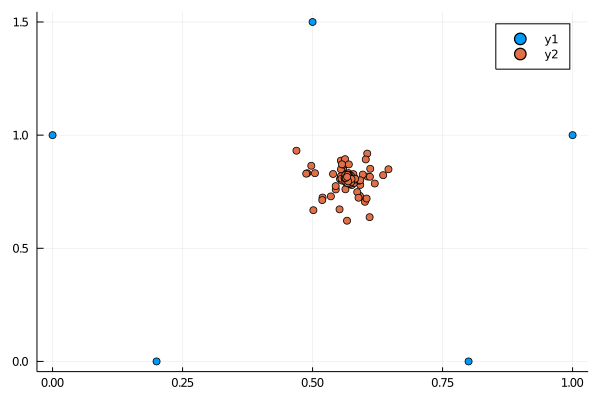

In [102]:
#example of embedding of circular graph into 2d space
n = 100

#fix 3 of the nodes to the edges of a triangle
fixed = [100,80,60,40,20]
fx = [0,1,1.5,1,0]
fy = [0.2, 0, 0.5, 1, 0.8]

#starting positions of nodes
xs = zeros(n-length(fixed))
ys = zeros(n-length(fixed))

#edges = get_loop_graph(n)
edges = get_random_graph(n,0.1)

display(edges)

#connecting the middle vertices

#edges = vcat(edges,(3,7))
#edges = vcat(edges,(3,11))
#edges = vcat(edges,(7,11))

#get the two systems, one for x and other for y
matx, bx = get_graph(n,edges,fixed,fx)
matx = mat_to_razprsena(matx)

maty, by = get_graph(n,edges,fixed,fy)
maty = mat_to_razprsena(maty)

its = zeros(10)
#solve the systems
for i=1:10
    xs = rand(Float64,n-length(fixed))
    ys = rand(Float64, n-length(fixed))
    
    xs, it1 = sor(matx,bx,xs,i/10,1e-5,10000)
    ys, it2 = sor(maty,by,ys,i/10,1e-5,10000)
    
    its[i] = it1+it2
end

#plot
plot(fy,fx,seriestype = :scatter)
plot!(ys,xs,seriestype = :scatter)



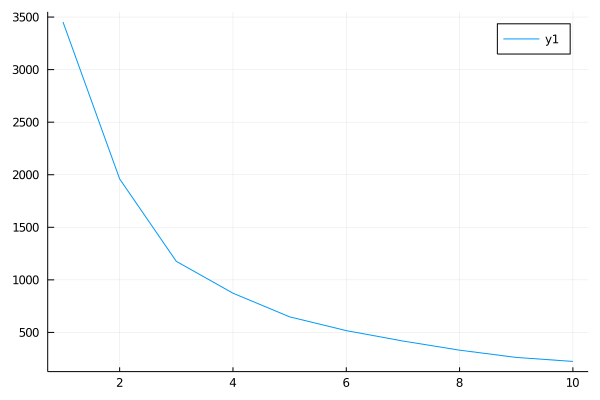

In [103]:
#plot number of iterations for convergence / the omega parameter

plot(its)

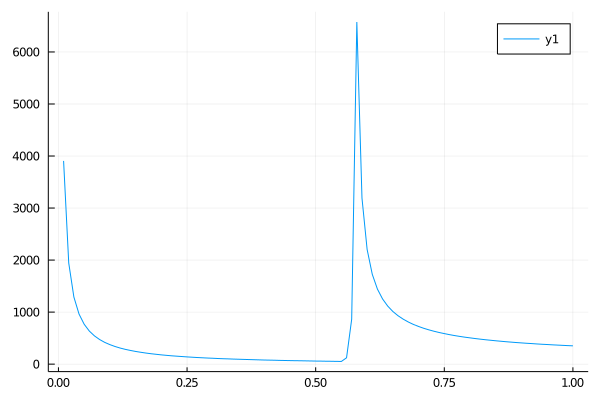

In [109]:
mat = RazprsenaMatrika([4 -1 -6 0; -5 -4 10 8; 9 4 -2 0; 1 -7 5 0], [1 2 3 0; 1 2 3 4; 2 3 4 0; 1 3 4 0] )
b = [2, 21, -12, -6]

x0 = [0.0, 0, 0, 0]

its = zeros(100)

#solve the system
for i=1:100
    x0 = [0.0, 0, 0, 0]
    
    x, it = sor(mat,b,x0,i/100,1e-10, 10000)
    
    its[i] = it
end

#plot number of iterations for convergence / the omega parameter

plot(0.01:0.01:1,its)

In [93]:
using Test

@testset "matrike" begin
    
    eps = 1e-5
    
    A = [1 2 0 ; 0 1 0 ; 0 1 2]
    
    Ar = RazprsenaMatrika([1 2; 1 0; 1 2], [1 2; 2 0 ; 2 3])

    @test norm(A-Ar)<eps
    
    A[1,3] = 3
    Ar[1,3] = 3
    
    @test norm(A-Ar)<eps
    
    A[1,3] = 0
    Ar[1,3] = 0
    
    @test norm(A-Ar)<eps
    
    x = [1, 2, 3]
    
    @test norm(A*x-Ar*x)<eps
    
    A = [1 2 0 0 0; 0 1 2 0 0; 0 0 1 2 0; 0 0 0 1 2]
      
    Ar = RazprsenaMatrika([1 2; 1 2; 1 2; 1 2;],[1 2; 2 3; 3 4; 4 5])
    
    @test norm(A-Ar)<eps
    
    A[1,3] = 3
    Ar[1,3] = 3
    
    @test norm(A-Ar)<eps
    
    A[1,3] = 0
    Ar[1,3] = 0
    
    @test norm(A-Ar)<eps
    
    x = [1, 2, 3, 4, 5]
    
    @test norm(A*x-Ar*x)<eps
    
    A = [1 0 3 0 0; 3 1 0 2 0; 1 1 0 0 0; 0 0 0 0 1; 0 1 2 3 0]
    
    Ar = mat_to_razprsena(A)
    
    @test norm(A-Ar)<eps
    
    A[1,3] = 3
    Ar[1,3] = 3
    
    @test norm(A-Ar)<eps
    
    A[1,3] = 0
    Ar[1,3] = 0
    
    @test norm(A-Ar)<eps
    
    x = [1, 2, 3, 4, 5]
    
    @test norm(A*x-Ar*x)<eps
    
end

@testset "sor" begin
    
    eps = 1e-5
    
    mat = RazprsenaMatrika([4 -1 -6 0; -5 -4 10 8; 9 4 -2 0; 1 -7 5 0], [1 2 3 0; 1 2 3 4; 2 3 4 0; 1 3 4 0] )
    b = [2, 21, -12, -6]
    
    x0 = [0.0, 0, 0, 0]
    
    x, it = sor(mat,b,x0,0.50,1e-10, 1000)
    
    @test norm(b-mat*x)<eps
    
    mat = mat_to_razprsena(rand(Float64,(5,5))+ I)
    mat[1,2] = mat[4,3] = mat[2,3] = mat[3,5] = 0
    
    b = rand(Float64,(5))
    x0 = rand(Float64,(5))
    
    x, it = sor(mat,b,x0,0.50,1e-10, 1000)
    
    @test norm(b-mat*x)<eps
    
    mat = mat_to_razprsena(rand(Float64,(15,15))+ 2*I)
    mat[1,2] = mat[4,3] = mat[2,3] = mat[3,5] = mat[10,2] = mat[7,3] = mat[2,13] = mat[10,12] = 0
    
    b = rand(Float64,(15))
    x0 = rand(Float64,(15))
    
    x, it = sor(mat,b,x0,0.5,1e-10, 1000)
    
    @test norm(b-mat*x)<eps
    
     
end

Test Summary: | Pass  Total
matrike       |   12     12
Test Summary: | Pass  Total
sor           |    3      3


Test.DefaultTestSet("sor", Any[], 3, false)

In [10]:
mat, b = get_graph(5, [(1,2),(2,3),(3,4),(4,5)], [5,1],[1,0])
mat = mat_to_razprsena(mat)
display(mat)
xs = [0.0,0.0,0.0]
sor(mat,b,xs,0.5,1e-3)

3×3 RazprsenaMatrika{Float64}:
 -2.0   1.0   0
  1.0  -2.0   1.0
  0     1.0  -2.0

3×3 RazprsenaMatrika{Float64}:
 -2.0   1.0   0
  1.0  -2.0   1.0
  0     1.0  -2.0

3-element Array{Float64,1}:
 0.0
 0.0
 0.0

3-element Array{Float64,1}:
  0.0
  0.0
 -1.0

3-element Array{Float64,1}:
 0.0
 0.0
 1.0

([0.24887050556559132, 0.4985533698790403, 0.7490735950197251], 31)

In [168]:
mat, b = get_graph(5, [(1,2),(2,3),(3,4),(4,5),(5,1),(2,4)], [5,1],[1,0])
mat = mat_to_razprsena(mat)
display(mat)
xs = [0.0,0.0,0.0]
sor(mat,b,xs,0.5,1e-3)

([0.373854586911712, 0.49858716527176977, 0.6239730991183194], 39)

In [76]:
xs = [0.0, 0.0, 0.0]
mat = [-1.0 1 0; 1 -2 1; 0 1 -1]
b = [0.0, 0.0, -1.0]

3-element Array{Float64,1}:
  0.0
  0.0
 -1.0

In [77]:
mat = RazprsenaMatrika([-2.0 1 0; 1 -2 1; 1 -2 0], [1 2 0; 1 2 3; 2 3 0])

3×3 RazprsenaMatrika{Float64}:
 -2.0   1.0   0
  1.0  -2.0   1.0
  0     1.0  -2.0

In [78]:
sor(mat,b,xs,0.5,1e-3)

([0.24887050556559132, 0.4985533698790403, 0.7490735950197251], 31)

In [47]:
mat

3×3 RazprsenaMatrika{Float64}:
 -1.0   1.0   0
  1.0  -2.0   1.0
  0     1.0  -1.0

In [65]:
function matrika(n, m)
    L = diagm(0=>-4*ones(n), 1=>ones(n-1), -1=>ones(n-1))
    I = diagm(0=>ones(n)) # identiteta
    A = zeros(n*m, n*m)
    for j=1:m
        k = ((j-1)*n+1):(j*n) # indeksi v j-tem bloku  
        A[k,k] = L
        if j < m
            A[k,k.+ n] = I
            A[k.+n, k] = I
        end
    end
    return A
end



matrika (generic function with 1 method)

In [69]:
matrika(2,2)

4×4 Array{Float64,2}:
 -4.0   1.0   1.0   0.0
  1.0  -4.0   0.0   1.0
  1.0   0.0  -4.0   1.0
  0.0   1.0   1.0  -4.0

In [68]:
function desne_strani(s, d, z, l)
    n = length(s)
    m = length(l)
    b = zeros(n*m)
    
    #display(b[1:n])
    #display(s)
    
    b[1:n] -= s # j = 1
    b[n:n:end] -= d # i = n
    b[end-n+1:end] -= z # j = m
    b[1:n:end-n+1] -= l # i = 1
    return b
end

desne_strani (generic function with 1 method)

In [70]:
desne_strani([0,1],[1,1],[0,1],[0,0])

4-element Array{Float64,1}:
  0.0
 -2.0
  0.0
 -2.0

In [18]:
mat = RazprsenaMatrika([4 -1 -6 0; -5 -4 10 8; 9 4 -2 0; 1 -7 5 0], [1 2 3 0; 1 2 3 4; 2 3 4 0; 1 3 4 0] )
display(mat)
b = [2, 21, -12, -6]
display(mat.I)
display(mat.V)

4×4 RazprsenaMatrika{Int64}:
  4  -1  -6   0
 -5  -4  10   8
  0   9   4  -2
  1   0  -7   5

4×4 Array{Int64,2}:
 1  2  3  0
 1  2  3  4
 2  3  4  0
 1  3  4  0

4×4 Array{Int64,2}:
  4  -1  -6  0
 -5  -4  10  8
  9   4  -2  0
  1  -7   5  0

In [26]:
sor(mat,b,[0.0,0,0,0],0.50,1e-10)

([2.9999999999668665, -2.0000000000005187, 1.9999999999934976, 0.9999999999946086], 59)

In [24]:
mat*[3.0,-2.0,2.0,1.0]

4-element Array{Float64,1}:
   2.0
  21.0
 -12.0
  -6.0

In [10]:
copy(mat)*[3.0,-2.0,2.0,1.0]

4-element Array{Float64,1}:
   2.0
  21.0
 -12.0
  -6.0

In [134]:
mat = RazprsenaMatrika([1 2; 2 6; 3 2],[1 3; 2 0 ; 3 0])

3×3 RazprsenaMatrika{Int64}:
 1  0  2
 0  2  0
 0  0  3

In [135]:
display(mat.I)
display(mat.V)

3×2 Array{Int64,2}:
 1  3
 2  0
 3  0

3×2 Array{Int64,2}:
 1  2
 2  6
 3  2

In [136]:
mat[1,3] = 5

5

In [137]:
display(mat.I)
display(mat.V)

3×3 Array{Int64,2}:
 1  3  0
 2  0  0
 3  0  0

3×3 Array{Int64,2}:
 1  5  0
 2  6  0
 3  2  0

In [138]:
v = [2,1,2]

3-element Array{Int64,1}:
 2
 1
 2

In [139]:
mat*v

3-element Array{Float64,1}:
  2.0
  2.0
 16.0

In [140]:
deepcopy(mat)*v

3-element Array{Float64,1}:
  2.0
  2.0
 16.0

In [12]:
struct PasovnaMatrika{T} <: AbstractArray{T,2}
        d::Vector{T}  
        s::Vector{Vector{T}}
        z::Vector{Vector{T}}
end

function size(A::PasovnaMatrika)
    return (size(A.d)[1],size(A.d)[1])
end

function getindex(A::PasovnaMatrika, I::Vararg{Int,2})
     return 1
end

getindex (generic function with 203 methods)

In [13]:
PasovnaMatrika([1,2,3],[[2,2]],[[3]])



3×3 PasovnaMatrika{Int64}:
 1  1  1
 1  1  1
 1  1  1

In [84]:
mat = [1 2 ; 1 2 ; 1 2]

3×2 Array{Int64,2}:
 1  2
 1  2
 1  2

In [86]:
v = [ 3; 3; 3]

3-element Array{Int64,1}:
 3
 3
 3

In [91]:
hcat(mat,v)

3×3 Array{Int64,2}:
 1  2  3
 1  2  3
 1  2  3

In [120]:
hcat(mat,zeros(3))
mat

3×3 RazprsenaMatrika{Int64}:
 1  2  0
 0  2  3
 3  4  0